# Toxic Comment Classification Challenge
## BERT - TensorFlow 2 & Hugging Face Transformers Library

In [1]:
#DON'T TOUCH!!
!pip install transformers
!pip install tensorflow==2.1.0
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8 MB 20 kB/s 
     |████████████████████████████████| 26.1 MB 41.9 MB/s 
     |████████████████████████████████| 3.8 MB 21.3 MB/s 
     |████████████████████████████████| 448 kB 55.2 MB/s 
     |████████████████████████████████| 50 kB 4.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=2b1c5f53075e68fd0d5ae91f4f3624f1dfe5df21ab847bab087ae2450941f581
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: scipy
    Found existing instal

In [2]:
dataset_directory = '../input/aldon-preprocessed'

In [3]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras

## 1. Data Pipeline
- Loading the datasets from CSVs
- Preprocessing (Tokenization, Truncation & Padding)
- Creating efficient data pipelines using tf.data

In [4]:
train_path = '../input/aldon-preprocessed-2/preprocessed_train_data.csv'
test_path = '../input/aldon-preprocessed-2/preprocessed_test_data.csv'
test_labels_path = '../input/aldon-preprocessed-2/test_label.csv'
subm_path = '../input/aldon-preprocessed/sample_submission.csv'

In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test_labels = df_test_labels.set_index('id')

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,insult,threat,identity_hate
0,0000997932d777bf,di saat semua cowok berusaha melacak perhatia...,1,0,0,1,0,0
1,000103f0d9cfb60f,siapa yang telat memberi tau kamu edan sarap ...,0,0,0,0,0,0
2,000113f07ec002fd,41 kadang aku berpikir kenapa aku tetap percay...,0,0,0,0,0,0
3,0001b41b1c6bb37e,aku itu aku dan ku tau matamu sipit tapi dili...,0,0,0,0,0,0
4,0001d958c54c6e35,kaum cebong kafir sudah kelihatan dongoknya d...,1,0,0,1,0,1


In [6]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,insult,threat,identity_hate
0,00001cee341fdb12,2 dalam perjalanannya kali ini presiden didamp...,1,0,1,0,0,0
1,0000247867823ef7,oi kepala aku tak sebesar itu ngewe,0,0,0,0,0,0
2,00013b17ad220c46,ada yang punya pengalaman urus surat administr...,0,0,0,0,0,0
3,00017563c3f7919a,atasi setan yang bernama cinta,0,0,0,0,0,0
4,00017695ad8997eb,coba kalau ahok yang berbicara begitu pasti b...,1,0,0,0,0,1


In [7]:
#Checking types of each columns from df_train
empDfObj = pd.DataFrame(df_train, columns=['id', 'comment_text', 'toxic', 'severe_toxic','obscene','threat','insult','indentity_hate'])
print('Data type of each column of Dataframe :')
dataTypeSeries = empDfObj.dtypes

print(dataTypeSeries)

Data type of each column of Dataframe :
id                 object
comment_text       object
toxic               int64
severe_toxic        int64
obscene             int64
threat              int64
insult              int64
indentity_hate    float64
dtype: object


In [8]:
#Checking types of each columns from df_test
empDfObj = pd.DataFrame(df_test, columns=['id', 'comment_text'])
print('Data type of each column of Dataframe :')
dataTypeSeries = empDfObj.dtypes

print(dataTypeSeries)

Data type of each column of Dataframe :
id              object
comment_text    object
dtype: object


In [9]:
#Initialize Bert tokenizer and masks
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'indobenchmark/indobert-base-p1'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['comment_text'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)


Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

  0%|          | 0/10057 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
from sklearn.model_selection import train_test_split

labels =  df_train[label_cols].values
test_labels = df_test[label_cols].values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [11]:
#Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
REPLICAS:  8


In [12]:
#Create train and validation datasets
BATCH_SIZE=32 
NR_EPOCHS=1
def create_dataset(data_tuple, epochs, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 2. BERT Model
- Load the pretrained BERT base-model from Transformers library
- Take the first hidden-state from BERT output (corresponding to CLS token) and feed it into a Dense layer with 6 neurons and sigmoid activation (Classifier). The outputs of this layer can be interpreted as probabilities for each of the 6 classes.

In [13]:
from transformers import TFBertModel

from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
        def __init__(self, bert: TFBertModel, num_classes: int):
            super().__init__()
            self.bert = bert
            self.classifier = Dense(num_classes, activation='sigmoid')

        @tf.function
        def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
            outputs = self.bert(input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   head_mask=head_mask)
            cls_output = outputs[1]
            cls_output = self.classifier(cls_output)

            return cls_output
        
model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## 3. Training Loop
- Use BinaryCrossentropy as loss function (is calculated for each of the output 6 output neurons ...that's like training 6 binary classification tasks at the same time) 
- Use the Adam optimizer 
- AUC evaluation metrics

In [14]:
import time
from transformers import create_optimizer
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


lw = 2
steps_per_epoch = (train_size // BATCH_SIZE) * NR_EPOCHS
validation_steps = (validation_size // BATCH_SIZE) * NR_EPOCHS

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer 
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = tf.keras.optimizers.Adam(lr=2e-5)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)
    
    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)
    #Loss Function into gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    #Apply gradient to optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
fpr = dict()
tpr = dict()
roc_auc = dict()
n_class = 6

        
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch+1}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 280 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()

        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')
    


train(model, train_dataset, validation_dataset, steps_per_epoch, validation_steps, NR_EPOCHS)


================================================== EPOCH 1 ==================================================


  0%|          | 0/282 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.9163799285888672
toxic roc_auc 0.3235294222831726
severe_toxic roc_auc 0.18965516984462738
obscene roc_auc 0.0
insult roc_auc 0.3589743673801422
threat roc_auc 0.0
identity_hate roc_auc 0.3839285671710968

Train Step: 280, Loss: 0.2324671894311905
toxic roc_auc 0.8896430730819702
severe_toxic roc_auc 0.9275965690612793
obscene roc_auc 0.858647882938385
insult roc_auc 0.8233226537704468
threat roc_auc 0.8764334917068481
identity_hate roc_auc 0.8842222690582275


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1, Validation Loss: 0.20081360638141632, Time: 803.010516166687

toxic roc_auc 0.9122359156608582
severe_toxic roc_auc 0.9902456998825073
obscene roc_auc 0.932084321975708
insult roc_auc 0.8497213125228882
threat roc_auc 0.9091565012931824
identity_hate roc_auc 0.9064769744873047




## 4. Run predictions on test-set & save submission

In [15]:
test_input_ids = tokenize_sentences(df_test['comment_text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

  0%|          | 0/3001 [00:00<?, ?it/s]

In [16]:
# Metrics
labelstest = np.array(labels)
test_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

TEST_BATCH_SIZE = 32
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks, test_labels), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

df_submission = pd.read_csv(subm_path, index_col='id')

for i, (token_ids, masks, labels) in enumerate(tqdm(test_dataset, total=test_steps)):
    sample_ids = df_test.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['id'] 
    predictions = model(token_ids, attention_mask=masks).numpy()
    for i, auc in enumerate(test_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
    
    df_submission.loc[sample_ids, label_cols] = predictions

  0%|          | 0/93 [00:00<?, ?it/s]

In [17]:
label_acc=[0,0,0,0,0,0] 
print("Testing Accuracy : ")
for i, label_name in enumerate(label_cols):
    print(f"{label_name} roc_auc {test_auc_metrics[i].result()}")
    label_acc[i] = test_auc_metrics[i].result()
    test_auc_metrics[i].reset_states()
    
    
labelnames = np.array(label_acc)
df_submission2 = df_submission[:3001]
labelspred = df_submission2[label_cols].values
labelstrue = df_test[label_cols].values

Testing Accuracy : 
toxic roc_auc 0.9301210641860962
severe_toxic roc_auc 0.9656968116760254
obscene roc_auc 0.9101719856262207
insult roc_auc 0.8611066341400146
threat roc_auc 0.9546165466308594
identity_hate roc_auc 0.9224561452865601


In [18]:
df_submission.to_csv('submission.csv')

In [19]:
def show_graph(labels, predictions, label):
    #For graphs
   
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(labels[:,i], predictions[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(1)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'slategrey', 'firebrick', 'springgreen'])
    for i, color in zip(range(n_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label='ROC curve of class '+ label_cols[i] + ' : ' + str(label[i]) )

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of all 6 classes')
    plt.legend(loc="lower right")
    plt.show()
    


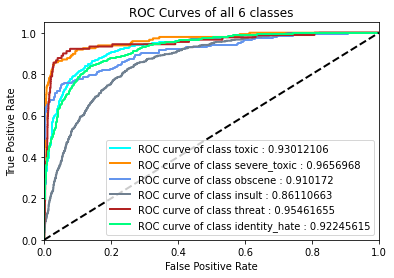

In [20]:
show_graph(labelstrue, labelspred, labelnames)